# Exporter
-----
an attempt to combine YOLO model with AnBev Model (not working, yet)

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# load tf saved model
model = tf.saved_model.load(rf"models\best_saved_model")

In [6]:
type(model)

tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject

In [44]:
# load image
img = tf.io.read_file(rf"G:\My Drive\dataset\geng-1\train\images\img_02.jpg")
img = tf.image.decode_jpeg(img, channels=3)
img = tf.image.resize(img, [640, 640])
img = img / 255.0
img = tf.expand_dims(img, 0)

In [4]:
# from ultralytics.nn.autobackend import AutoBackend
import torch
import cv2

In [5]:
# load image using torch
orig_img = cv2.imread(rf"G:\My Drive\dataset\geng-1\train\images\img_02.jpg")
orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
# img = cv2.resize(img, (640, 640))
# img = img / 255.0
# img = np.expand_dims(img, axis=0)
# img = torch.from_numpy(img)

In [6]:
from ultralytics.data.augment import LetterBox

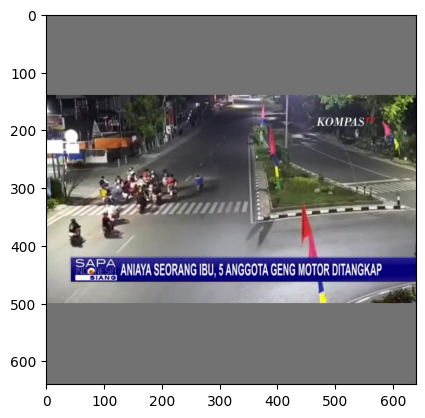

In [7]:
lb = LetterBox()
lb_img = lb(image=orig_img)
plt.imshow(lb_img)

In [10]:
img = np.stack([lb_img]) / 255.0
img = np.ascontiguousarray(img)


In [11]:
img.shape

(1, 640, 640, 3)

In [12]:
out = model(tf.convert_to_tensor(img, dtype=tf.float32))
out.shape

TensorShape([1, 5, 8400])

In [26]:
out

<tf.Tensor: shape=(1, 5, 8400), dtype=float32, numpy=
array([[[  0.0055752,    0.025718,     0.03729, ...,     0.79972,     0.84227,      0.9178],
        [  0.0097876,   0.0054354,   0.0047789, ...,     0.90875,     0.90477,     0.94971],
        [   0.012374,    0.045563,    0.062618, ...,     0.45051,     0.46677,     0.50582],
        [   0.019304,    0.011266,   0.0097523, ...,     0.27883,     0.23031,     0.22488],
        [ 0.00011662,  9.1038e-05,  1.0102e-05, ...,  3.8428e-06,   3.405e-06,  2.8781e-06]]], dtype=float32)>

In [34]:
out[0, ..., 99]

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([    0.24025,    0.017256,    0.097712,    0.033885,  1.7353e-06], dtype=float32)>

In [21]:
out_tensor = torch.from_numpy(out.numpy())
out_tensor.shape

torch.Size([1, 5, 8400])

In [22]:
from ultralytics.utils.ops import non_max_suppression
res = non_max_suppression(out_tensor, agnostic=True)
res[0]

tensor([[0.1493, 0.5348, 0.1848, 0.6062, 0.8208, 0.0000],
        [0.1434, 0.4642, 0.1795, 0.5156, 0.8075, 0.0000],
        [0.4025, 0.4317, 0.4260, 0.4852, 0.7814, 0.0000],
        [0.0601, 0.5508, 0.0958, 0.6252, 0.7750, 0.0000],
        [0.2442, 0.4811, 0.2731, 0.5385, 0.7368, 0.0000],
        [0.1845, 0.4362, 0.2088, 0.4829, 0.7356, 0.0000],
        [0.2182, 0.4140, 0.2466, 0.4554, 0.7289, 0.0000],
        [0.3282, 0.4516, 0.3553, 0.5062, 0.7289, 0.0000],
        [0.2039, 0.4523, 0.2359, 0.5073, 0.7136, 0.0000],
        [0.2598, 0.4167, 0.2827, 0.4605, 0.7016, 0.0000],
        [0.3114, 0.4171, 0.3321, 0.4621, 0.6999, 0.0000],
        [0.2855, 0.4628, 0.3136, 0.5159, 0.6626, 0.0000],
        [0.1436, 0.4373, 0.1695, 0.4719, 0.5747, 0.0000],
        [0.2823, 0.4197, 0.3031, 0.4627, 0.4648, 0.0000],
        [0.1623, 0.5136, 0.1995, 0.5573, 0.2996, 0.0000]])

In [31]:
from ultralytics.utils.ops import xywh2xyxy
import time

def TF_non_max_suppression(
    prediction,
    conf_thres=0.25,
    iou_thres=0.45,
    classes=None,
    agnostic=False,
    multi_label=False,
    labels=(),
    max_det=300,
    nc=0,  # number of classes (optional)
    max_time_img=0.05,
    max_nms=30000,
    max_wh=7680,
    in_place=True,
):
    """
    Perform non-maximum suppression (NMS) on a set of boxes, with support for masks and multiple labels per box.

    Args:
        prediction (tf.Tensor): A tensor of shape (batch_size, num_classes + 4 + num_masks, num_boxes)
            containing the predicted boxes, classes, and masks. The tensor should be in the format
            output by a model, such as YOLO.
        conf_thres (float): The confidence threshold below which boxes will be filtered out.
            Valid values are between 0.0 and 1.0.
        iou_thres (float): The IoU threshold below which boxes will be filtered out during NMS.
            Valid values are between 0.0 and 1.0.
        classes (List[int]): A list of class indices to consider. If None, all classes will be considered.
        agnostic (bool): If True, the model is agnostic to the number of classes, and all
            classes will be considered as one.
        multi_label (bool): If True, each box may have multiple labels.
        labels (List[List[Union[int, float, tf.Tensor]]]): A list of lists, where each inner
            list contains the apriori labels for a given image. The list should be in the format
            output by a dataloader, with each label being a tuple of (class_index, x1, y1, x2, y2).
        max_det (int): The maximum number of boxes to keep after NMS.
        nc (int, optional): The number of classes output by the model. Any indices after this will be considered masks.
        max_time_img (float): The maximum time (seconds) for processing one image.
        max_nms (int): The maximum number of boxes into torchvision.ops.nms().
        max_wh (int): The maximum box width and height in pixels.
        in_place (bool): If True, the input prediction tensor will be modified in place.

    Returns:
        (List[tf.Tensor]): A list of length batch_size, where each element is a tensor of
            shape (num_boxes, 6 + num_masks) containing the kept boxes, with columns
            (x1, y1, x2, y2, confidence, class, mask1, mask2, ...).
    """
    # Checks
    assert 0 <= conf_thres <= 1, f"Invalid Confidence threshold {conf_thres}, valid values are between 0.0 and 1.0"
    assert 0 <= iou_thres <= 1, f"Invalid IoU {iou_thres}, valid values are between 0.0 and 1.0"
    if isinstance(prediction, (list, tuple)):  # YOLOv8 model in validation model, output = (inference_out, loss_out)
        prediction = prediction[0]  # select only inference output

    bs = prediction.shape[0]  # batch size
    nc = nc or (prediction.shape[1] - 4)  # number of classes
    nm = prediction.shape[1] - nc - 4
    mi = 4 + nc  # mask start index
    xc = tf.reduce_max(prediction[:, 4:mi], axis=1) > conf_thres  # candidates

    # Settings
    time_limit = 2.0 + max_time_img * bs  # seconds to quit after
    multi_label &= nc > 1  # multiple labels per box

    prediction = tf.transpose(prediction, perm=[0, 2, 1])  # shape (1, 84, 6300) to shape (1, 6300, 84)
    if in_place:
        prediction[..., :4] = xywh2xyxy(prediction[..., :4])  # xywh to xyxy
    else:
        prediction = tf.concat([xywh2xyxy(prediction[..., :4]), prediction[..., 4:]], axis=-1)  # xywh to xyxy

    t = time.time()
    output = [tf.zeros((0, 6 + nm))] * bs
    for xi, x in enumerate(prediction):  # image index, image inference
        # Apply constraints
        x = tf.boolean_mask(x, xc[xi])  # confidence

        # Cat apriori labels if autolabelling
        if labels and len(labels[xi]):
            lb = labels[xi]
            v = tf.zeros((len(lb), nc + nm + 4))
            v[:, :4] = xywh2xyxy(lb[:, 1:5])  # box
            v = tf.tensor_scatter_nd_update(v, tf.stack([tf.range(len(lb)), tf.cast(lb[:, 0], tf.int32) + 4], axis=1), tf.ones(len(lb)))  # cls
            x = tf.concat([x, v], axis=0)

        # If none remain process next image
        if x.shape[0] == 0:
            continue

        # Detections matrix nx6 (xyxy, conf, cls)
        box, cls, mask = tf.split(x, [4, nc, nm], axis=1)

        if multi_label:
            i, j = tf.where(cls > conf_thres)
            x = tf.concat([tf.gather(box, i), tf.expand_dims(tf.gather_nd(x[:, 4:], tf.stack([i, j], axis=1)), axis=1), tf.cast(tf.expand_dims(j, axis=1), tf.float32), tf.gather(mask, i)], axis=1)
        else:  # best class only
            conf = tf.reduce_max(cls, axis=1, keepdims=True)
            j = tf.argmax(cls, axis=1, output_type=tf.int32)
            x = tf.concat([box, conf, tf.cast(tf.expand_dims(j, axis=1), tf.float32), mask], axis=1)
            x = tf.boolean_mask(x, tf.squeeze(conf, axis=1) > conf_thres)

        # Filter by class
        if classes is not None:
            x = tf.boolean_mask(x, tf.reduce_any(tf.equal(tf.expand_dims(x[:, 5], axis=1), tf.constant(classes, dtype=tf.float32)), axis=1))

        # Check shape
        n = x.shape[0]  # number of boxes
        if n == 0:  # no boxes
            continue
        if n > max_nms:  # excess boxes
            x = tf.gather(x, tf.argsort(x[:, 4], direction='DESCENDING')[:max_nms])  # sort by confidence and remove excess boxes

        # Batched NMS
        c = x[:, 5:6] * (0 if agnostic else max_wh)  # classes
        c = tf.concat([c, c, tf.zeros_like(c), tf.zeros_like(c)], axis=1)  # correct shape for addition
        scores = x[:, 4]  # scores
        boxes = x[:, :4] + c  # boxes (offset by class)
        i = tf.image.non_max_suppression(boxes, scores, max_output_size=max_det, iou_threshold=iou_thres)
        i = i[:max_det]  # limit detections

        output[xi] = tf.gather(x, i)
        if (time.time() - t) > time_limit:
            print(f"WARNING ⚠️ NMS time limit {time_limit:.3f}s exceeded")
            break  # time limit exceeded

    return output


In [33]:
res_tf = TF_non_max_suppression(out, agnostic=True, in_place=False)
res_tf[0][:4]

<tf.Tensor: shape=(15, 6), dtype=float32, numpy=
array([[    0.14934,     0.53483,     0.18478,     0.60618,     0.82081,           0],
       [    0.14337,     0.46417,     0.17954,     0.51555,     0.80749,           0],
       [    0.40247,     0.43174,       0.426,     0.48522,     0.78145,           0],
       [   0.060124,     0.55081,    0.095829,     0.62519,     0.77499,           0],
       [    0.24416,     0.48109,     0.27309,     0.53851,      0.7368,           0],
       [    0.18453,     0.43615,     0.20883,     0.48288,     0.73561,           0],
       [    0.21815,     0.41402,     0.24664,     0.45541,     0.72895,           0],
       [    0.32815,     0.45157,     0.35526,      0.5062,     0.72886,           0],
       [     0.2039,     0.45229,      0.2359,     0.50727,      0.7136,           0],
       [    0.25983,     0.41671,     0.28268,     0.46048,      0.7016,           0],
       [    0.31136,     0.41713,     0.33208,     0.46209,      0.6999,         

In [36]:
res_tf[0][0, :4]

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([    0.14934,     0.53483,     0.18478,     0.60618], dtype=float32)>

In [40]:
from ultralytics.utils.ops import xyxy2xywh
xyxy2xywh(res_tf[0][..., :4])

array([[    0.16706,     0.57051,    0.035434,    0.071346],
       [    0.16146,     0.48986,    0.036163,    0.051385],
       [    0.41423,     0.45848,    0.023533,    0.053475],
       [   0.077977,       0.588,    0.035705,    0.074374],
       [    0.25863,      0.5098,     0.02893,    0.057426],
       [    0.19668,     0.45951,    0.024306,    0.046723],
       [     0.2324,     0.43472,     0.02849,    0.041393],
       [    0.34171,     0.47889,    0.027107,    0.054626],
       [     0.2199,     0.47978,    0.031998,    0.054986],
       [    0.27125,     0.43859,     0.02285,     0.04376],
       [    0.32172,     0.43961,    0.020726,    0.044965],
       [    0.29957,     0.48936,    0.028086,    0.053068],
       [    0.15653,     0.45459,    0.025946,    0.034667],
       [     0.2927,     0.44118,    0.020866,    0.043009],
       [    0.18092,     0.53547,    0.037248,     0.04373]], dtype=float32)

In [60]:
res[0].shape

torch.Size([15, 6])

In [61]:
orig_img.shape[:2]

(576, 1024)

In [49]:
from ultralytics.utils.ops import xywhn2xyxy
xywhn2xyxy(res[0][0, :4], w=1024, h=576).numpy()

array([     58.321,      133.48,      247.53,      482.64], dtype=float32)

In [76]:
from ultralytics.utils.ops import scale_boxes
def draw_bounding_box(pred, img):
    img = (img.copy()).astype(np.uint8)
    # print(img.shape)
    lb_shape = lb_img.shape
    h, w, _ = img.shape
    for detection in pred:        
        box = detection[:4]
        box = scale_boxes(lb_shape, box, (h, w))
        x1, y1, x2, y2 = box
        # x1, y1, x2, y2 = xywhn2xyxy(detection[0:4], w=img.shape[1], h=img.shape[0])
        x1, y1, x2, y2 = int(x1 * w), int(y1 * h), int(x2 * w), int(y2 * h)
        # print(x1, y1, x2, y2)
        img = cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

    return img

In [89]:
res[0][0, :4]

tensor([0.1493, 0.5348, 0.1848, 0.6062])

In [88]:
res_copy = res[0].clone()
scale_boxes(lb_img.shape, res_copy[0, :4], (576, 1024))

tensor([0.2389, 0.0000, 0.2956, 0.0000])

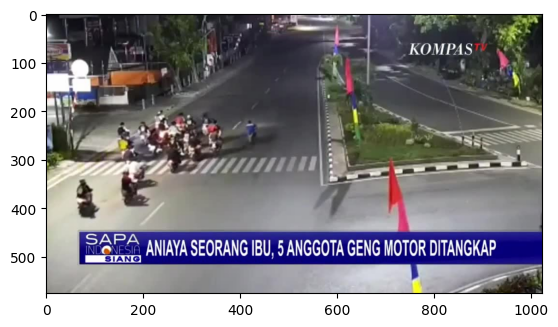

In [74]:


orig_img = cv2.imread(rf"G:\My Drive\dataset\geng-1\train\images\img_02.jpg")
orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
# orig_img = np.ascontiguousarray(orig_img)
anotated = draw_bounding_box(res[0], orig_img)
plt.imshow(anotated)

In [5]:
from ultralytics import YOLO

yolo = YOLO(rf"models\best.pt")
results = yolo(rf"G:\My Drive\dataset\geng-1\train\images\img_02.jpg")



image 1/1 G:\My Drive\dataset\geng-1\train\images\img_02.jpg: 384x640 15 motors, 254.7ms
Speed: 14.3ms preprocess, 254.7ms inference, 1093.2ms postprocess per image at shape (1, 3, 384, 640)


In [19]:
trk = yolo.track(np.random.random((1, 756, 1024, 3)))

error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:3789: error: (-215:Assertion failed) !dsize.empty() in function 'cv::hal::resize'


In [176]:
res[0].tolist()[0][1] * 640

144.0560531616211

In [6]:
results[0].boxes.data

tensor([[1.5290e+02, 3.2372e+02, 1.8913e+02, 3.9678e+02, 8.2229e-01, 0.0000e+00],
        [1.4681e+02, 2.5131e+02, 1.8387e+02, 3.0393e+02, 8.0740e-01, 0.0000e+00],
        [4.1211e+02, 2.1810e+02, 4.3623e+02, 2.7289e+02, 7.8185e-01, 0.0000e+00],
        [6.1564e+01, 3.4004e+02, 9.8170e+01, 4.1644e+02, 7.7700e-01, 0.0000e+00],
        [2.5001e+02, 2.6865e+02, 2.7964e+02, 3.2744e+02, 7.3797e-01, 0.0000e+00],
        [1.8895e+02, 2.2262e+02, 2.1388e+02, 2.7044e+02, 7.3540e-01, 0.0000e+00],
        [2.2339e+02, 1.9999e+02, 2.5256e+02, 2.4229e+02, 7.2935e-01, 0.0000e+00],
        [3.3602e+02, 2.3841e+02, 3.6380e+02, 2.9436e+02, 7.2924e-01, 0.0000e+00],
        [2.0879e+02, 2.3918e+02, 2.4156e+02, 2.9544e+02, 7.1357e-01, 0.0000e+00],
        [2.6606e+02, 2.0273e+02, 2.8951e+02, 2.4752e+02, 7.0152e-01, 0.0000e+00],
        [3.1882e+02, 2.0314e+02, 3.4008e+02, 2.4918e+02, 7.0028e-01, 0.0000e+00],
        [2.9237e+02, 2.5001e+02, 3.2115e+02, 3.0430e+02, 6.6312e-01, 0.0000e+00],
        [1.4700e

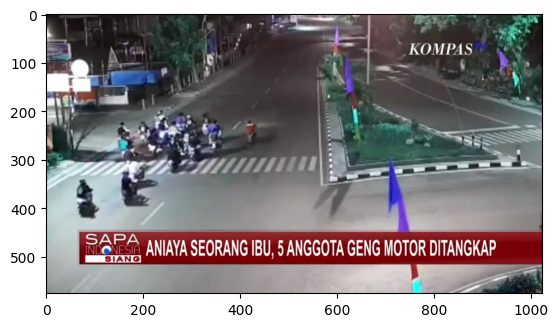

In [172]:
plt.imshow(results[0].orig_img)

In [38]:
res[0]

tensor([[0.1493, 0.5348, 0.1848, 0.6062, 0.8208, 0.0000],
        [0.1434, 0.4642, 0.1795, 0.5156, 0.8075, 0.0000],
        [0.4025, 0.4317, 0.4260, 0.4852, 0.7814, 0.0000],
        [0.0601, 0.5508, 0.0958, 0.6252, 0.7750, 0.0000],
        [0.2442, 0.4811, 0.2731, 0.5385, 0.7368, 0.0000],
        [0.1845, 0.4362, 0.2088, 0.4829, 0.7356, 0.0000],
        [0.2182, 0.4140, 0.2466, 0.4554, 0.7289, 0.0000],
        [0.3282, 0.4516, 0.3553, 0.5062, 0.7289, 0.0000],
        [0.2039, 0.4523, 0.2359, 0.5073, 0.7136, 0.0000],
        [0.2598, 0.4167, 0.2827, 0.4605, 0.7016, 0.0000],
        [0.3114, 0.4171, 0.3321, 0.4621, 0.6999, 0.0000],
        [0.2855, 0.4628, 0.3136, 0.5159, 0.6626, 0.0000],
        [0.1436, 0.4373, 0.1695, 0.4719, 0.5747, 0.0000],
        [0.2823, 0.4197, 0.3031, 0.4627, 0.4648, 0.0000],
        [0.1623, 0.5136, 0.1995, 0.5573, 0.2996, 0.0000]])

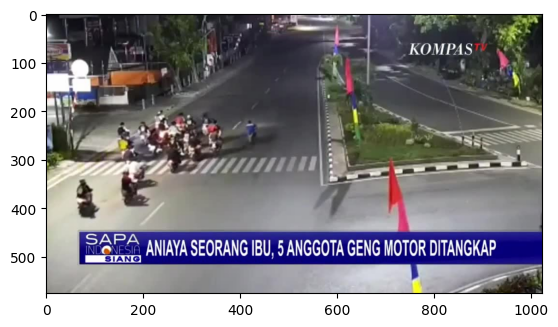

In [50]:
from ultralytics.utils.plotting import Annotator

annotator = Annotator(orig_img.copy())
for box in res[0].tolist():
    annotator.box_label(box, color=(255, 0 , 0))
plt.imshow(annotator.result())

In [5]:
a = tf.random.normal((1, 5))
a

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[-0.6046258 , -0.65412885,  0.73764116,  0.46126124, -1.8953842 ]],
      dtype=float32)>

In [6]:
for i in range(4):
    b = tf.random.normal((1, 5))
    a = tf.keras.layers.Concatenate(axis=0)([a, b])
a

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[-0.6046258 , -0.65412885,  0.73764116,  0.46126124, -1.8953842 ],
       [-1.2902478 , -1.6760793 , -0.7487075 , -1.2593205 ,  0.05114862],
       [ 0.11978072,  0.2871914 , -3.6189008 ,  0.62657917, -0.3057768 ],
       [-0.19598377,  0.5191299 , -1.1648754 ,  0.45944485, -0.993338  ],
       [ 0.65707225, -0.96673363,  0.03917748, -1.0650002 , -0.03628546]],
      dtype=float32)>

In [2]:
class DetDummy(tf.keras.layers.Layer):
    def __init__(self):
        super(DetDummy, self).__init__()

    def call(self, x):
        x = tf.random.normal((1, 5))
        return x


In [9]:
inp = tf.keras.Input(shape=(5,))
dum = DetDummy()
# dum = tf.keras.layers.Dense(5)
x = dum(inp)

for i in range(4):
    y = dum(x)
    x = tf.keras.layers.Concatenate(axis=0)([x, y])

# x = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(inputs=inp, outputs=x)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 5)]                  0         []                            
                                                                                                  
 det_dummy_2 (DetDummy)      (1, 5)                       0         ['input_4[0][0]',             
                                                                     'det_dummy_2[0][0]',         
                                                                     'concatenate_12[0][0]',      
                                                                     'concatenate_13[0][0]',      
                                                                     'concatenate_14[0][0]']      
                                                                                            

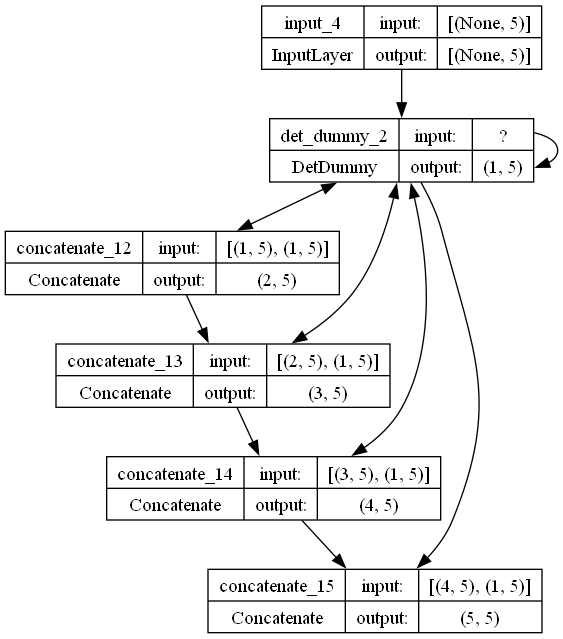

In [10]:
tf.keras.utils.plot_model(model, show_shapes=True)